In [135]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.signal
import pandas as pd
import get_ecg as ge
import read_ecg as re

# Importing the raw signals and annotations

In [136]:
""" Imports the DNN annotations as a dataframe """
dnn_annotations = pd.read_csv("./data/annotations/dnn.csv")
gold_standard = pd.read_csv("./data/annotations/gold_standard.csv")

""" Imports and cleans the raw signals """


def is_only_zero(li):
    return (np.sum(np.abs(li) < 0.0001) == len(li))


def has_dead_lead(lili):  # shape = (p,t)
    (p, t) = np.shape(lili)
    verdict = False
    for lead in range(p):
        verdict = verdict or is_only_zero(lili[lead])
    return verdict


def get_clean_ecg(tracings_file="./data/ecg_tracings.hdf5"):
    with h5py.File(tracings_file, "r") as f:
        ecg_tracings = np.swapaxes(np.array(f['tracings']), 1, 2)  # shape = (827,12,4096)
        bad_indexes = []
        for i in range(827):
            if has_dead_lead(ecg_tracings[i]):
                bad_indexes += [i]
        ecg_tracings = np.delete(ecg_tracings, bad_indexes, 0)  # Isolate and delete the bad indexes
    return (bad_indexes,
            np.array([[re.delete_zeros(ecg[lead]) for lead in range(12)] for ecg in ecg_tracings]))  # delete zeroes


(bad_indexes, table_ecg) = get_clean_ecg()
N_patients = np.shape(table_ecg)[0]
"""table_ecg has shape (N_patients, 12, _ (e.g. 4096))"""

print('*** Finished importing and cleaning the raw signals ***')

"""Removes the bad signals from the labels dataframes"""
dnn_annotations = dnn_annotations.drop(bad_indexes)
gold_standard = gold_standard.drop(bad_indexes)

print('*** Finished cleaning the label dataframes ***')

"""Names the different leads. These arrays have shape (813,_ (e.g. 4096))"""

table_ecg0 = table_ecg[:, 0]
table_ecg1 = table_ecg[:, 1]
table_ecg2 = table_ecg[:, 2]
table_ecg3 = table_ecg[:, 3]
table_ecg4 = table_ecg[:, 4]
table_ecg5 = table_ecg[:, 5]
table_ecg6 = table_ecg[:, 6]
table_ecg7 = table_ecg[:, 7]
table_ecg8 = table_ecg[:, 8]
table_ecg9 = table_ecg[:, 9]
table_ecg10 = table_ecg[:, 10]
table_ecg11 = table_ecg[:, 11]


*** Finished importing and cleaning the raw signals ***
*** Finished cleaning the label dataframes ***


# What the ECGs look like :  table_ecg[id][lead][time]

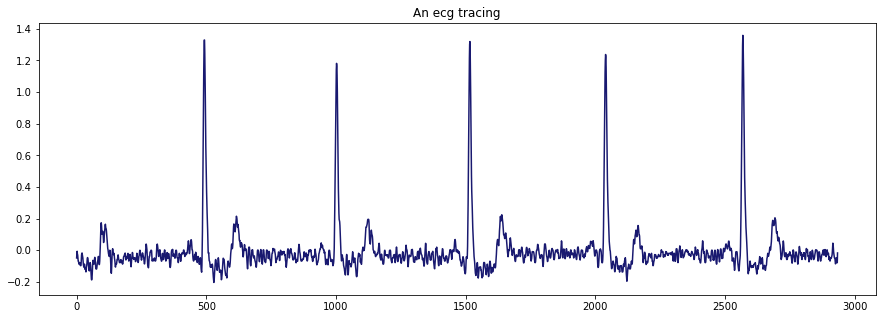

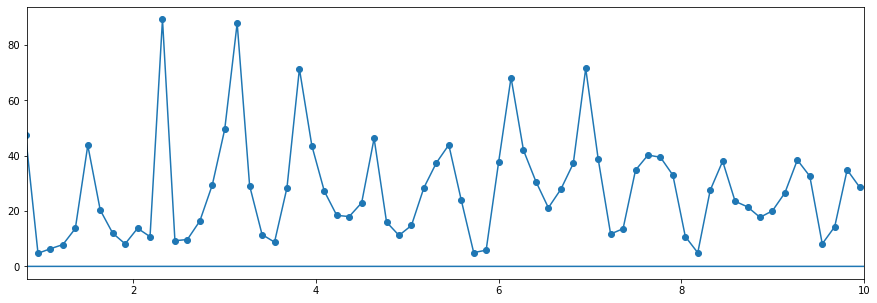

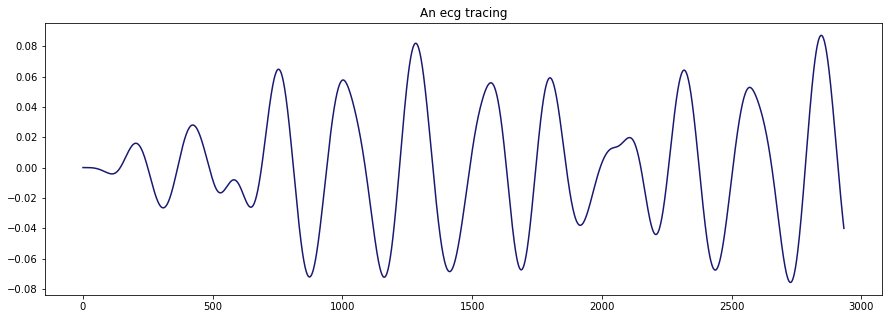

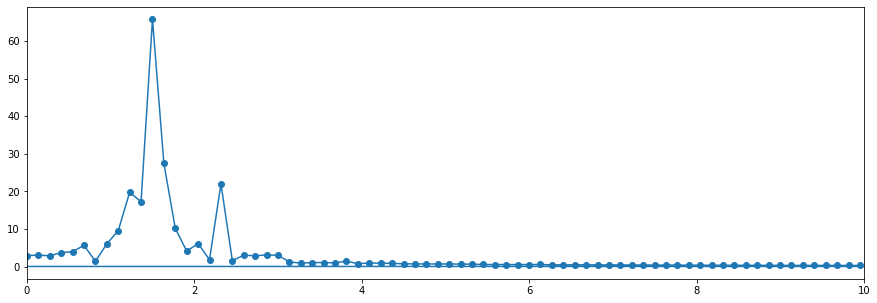

In [196]:
(patient_id,lead_number)=(709,0)

signal = table_ecg[patient_id][lead_number]

plt.figure(figsize=(15,5))
plt.plot(signal,'midnightblue')
plt.title('An ecg tracing')

plt.figure(figsize=(15,5))
plt.plot(np.fft.fftfreq(np.size(signal),1/400),np.abs(np.fft.fft(signal)),'-o')
plt.xlim([5/6,10])
plt.show()

"""Compute the Butterworth filter"""
a, b = scipy.signal.butter(N=4, Wn=[1,2], btype='bandpass',analog=False, output='ba',fs=400)

"""Filter the signal and save it"""
signal_new = scipy.signal.lfilter(a,b,signal)

plt.figure(figsize=(15,5))
plt.plot(signal_new,'midnightblue')
plt.title('An ecg tracing')

plt.figure(figsize=(15,5))
plt.plot(np.fft.fftfreq(np.size(signal_new),1/400),np.abs(np.fft.fft(signal_new)),'-o')
plt.xlim([0,10])
plt.show()


# Requirements for the period :

- Cannot be 0
- Tachycardia is generally defined as a heart rate over 100 beats per minute, let's take an upper bound of 120 bpm i.e. 2 Hz.
- Bradycardia is typically defined as a heart rate under 60 beats per minute, let's take a lower bound of 50 bpm i.e. 5/6 Hz.
- Must be found multiple times across all leads (1 person = 1 heartbeat)

Since we have a sampling frequency of $f_s = 400$ Hz, the number of steps of a single heartbeat is $T = \frac{f_s}{beats per second}$ steps.

Therefore the period should be between $\frac{400}{2}=200$ and $\frac{400}{5/6}=480$ steps.

# Method : frequency of max amplitude in FFT
## Poly_feature : the most appearing frequency

In [219]:
def period_via_fft(ecg_list):
    """Takes a 12-lead ecg and returns the most probable heartbeat period in number of steps (1 step = 1/400 s)"""
    potential_periods = []
    """Compute the Butterworth filter"""
    butter_a, butter_b = scipy.signal.butter(N=2,Wn=[50/60,120/60], btype='bandpass',analog=False, output='ba',fs=400)
    for k in range(12):
        filtered_ecg = scipy.signal.lfilter(butter_a,butter_b,ecg_list[k])
        signal_length = np.size(ecg_list[k])
        fft_k = np.fft.fft(filtered_ecg) #gets rid of a potential 0
        freq_k = np.fft.fftfreq(signal_length,1/400)
        resu = int(400/np.abs(freq_k[np.argmax(np.abs(fft_k))])) #the number of steps
        potential_periods.append(resu)
    return max(potential_periods,key=potential_periods.count) 

for k in range(0,np.shape(table_ecg)[0],100):
    print(period_via_fft(table_ecg[k]))

366
326
366
341
409
326
326
372
326


In [220]:
def frequency_via_fft(ecg_list):
    """Takes a 12-lead ecg and returns the most probable heartbeat frequency in bpm (1 step = 1/400 s)
    To do so it takes the frequency of maximum amplitude in the Fourier spectrum of each lead after passing it through
    a Butterworth filter of order 2 of bandpass [50 bpm, 120 bpm], then takes the frequency which appears the most
    across all leads"""
    potential_frequencies = []
    butter_a, butter_b = scipy.signal.butter(N=2, Wn=[50/60, 120/60], btype='bandpass', analog=False, output='ba', fs=400)
    for k in range(12):
        filtered_ecg = scipy.signal.lfilter(butter_a,butter_b,ecg_list[k])
        signal_length = np.size(ecg_list[k])
        fft_k = np.fft.fft(filtered_ecg)
        freq_k = np.fft.fftfreq(signal_length,1/400)
        resu = int(60*np.abs(freq_k[np.argmax(np.abs(fft_k))]))
        """converts frequency in Hz -> period in number of steps"""
        potential_frequencies.append(resu)
    return max(potential_frequencies, key=potential_frequencies.count)

for k in range(0,np.shape(table_ecg)[0],100):
    print(frequency_via_fft(table_ecg[k]))

65
73
65
70
58
73
73
64
73


## Mono_feature : individual frequency of each lead

In [227]:
def periods_via_fft(ecg):
    """Takes a single lead ecg and returns the most probable heartbeat period in number of steps (1 step = 1/400 s)"""
    """Compute the Butterworth filter"""
    butter_a, butter_b = scipy.signal.butter(N=2,Wn=[50/60,120/60], btype='bandpass',analog=False, output='ba',fs=400)
    filtered_ecg = scipy.signal.lfilter(butter_a,butter_b,ecg)
    signal_length = np.size(ecg)
    fft = np.fft.fft(filtered_ecg)
    freq = np.fft.fftfreq(signal_length,1/400)
    return int(400/np.abs(freq[np.argmax(np.abs(fft))])) #the number of steps
        
for k in range(12):
    print(periods_via_fft(table_ecg[2][k]))

266
266
266
266
266
266
266
266
266
266
266
266
